## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.regularizers import l2
from numpy.random import seed
seed(1)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

# from kerastuner.tuners import RandomSearch

Using TensorFlow backend.


### Horizontal Visual of the architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 15)                22095     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

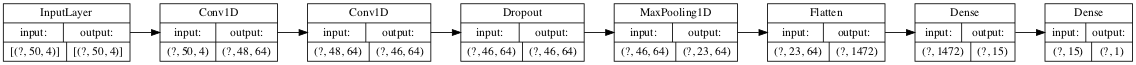

In [2]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(50, 4), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 5, verbose=1)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False,rankdir="LR",
    expand_nested=False,
    dpi=60,)

### Vertical view of the architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 48, 64)            832       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1472)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                73650     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

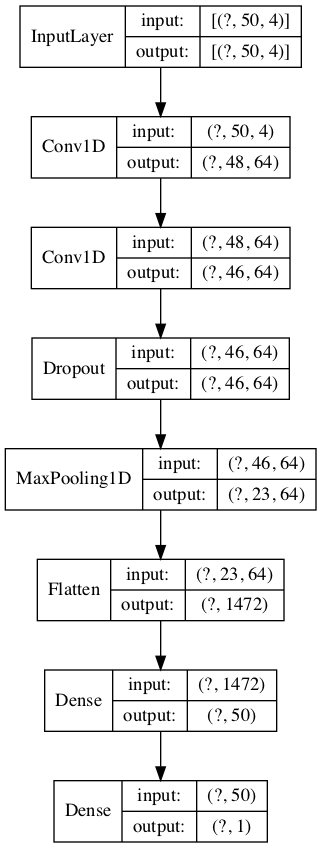

In [3]:
# { # With Feature Scaling
#     'drop1' : 0.5,
#     'w1' : 600.,
#     'w0' : 1.,
#     'batch' : 7500,
#     'epochs' : 5,
#     'patience' : 5,
#     'HL_1' : 50,
#     'HL_2' : 3,
#     'lr': 0.001,
#     'opt': 'nadam'
# }
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(50, 4), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)


## Read in Data

In [14]:
data_path = "./10ms_50rows/"
# x_S1_scaled_XYZ_10ms_50lb
S1_x = np.load(data_path + "x_S1_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
S1_y = np.load(data_path + "y_S1_scaled_XYZ_10ms_50lb.npy").astype(np.float32)

S2_x = np.load(data_path + "x_S2_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
S2_y = np.load(data_path + "y_S2_scaled_XYZ_10ms_50lb.npy").astype(np.float32)

S3_x = np.load(data_path + "x_S3_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
S3_y = np.load(data_path + "y_S3_scaled_XYZ_10ms_50lb.npy").astype(np.float32)

C1_x = np.load(data_path + "x_C1_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
C1_y = np.load(data_path + "y_C1_scaled_XYZ_10ms_50lb.npy").astype(np.float32)

C2_x = np.load(data_path + "x_C2_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
C2_y = np.load(data_path + "y_C2_scaled_XYZ_10ms_50lb.npy").astype(np.float32)

C3_x = np.load(data_path + "x_C3_scaled_XYZ_10ms_50lb.npy").astype(np.float32)
C3_y = np.load(data_path + "y_C3_scaled_XYZ_10ms_50lb.npy").astype(np.float32)


In [44]:
S1_x[0]

array([[ 0.65048856, -0.29491472,  0.04537556],
       [ 0.6443313 , -0.30964693,  0.04340368],
       [ 0.6350953 , -0.3219238 ,  0.06706619],
       [ 0.6073874 , -0.30801004,  0.11439119],
       [ 0.58429754, -0.34565908,  0.12720837],
       [ 0.58429754, -0.33338222,  0.12227868],
       [ 0.5612076 , -0.34565908,  0.1410115 ],
       [ 0.54581434, -0.35548055,  0.15284275],
       [ 0.50579184, -0.3702128 ,  0.17946307],
       [ 0.50117385, -0.37512353,  0.19819587],
       [ 0.50579184, -0.39885882,  0.22185838],
       [ 0.46115136, -0.39558497,  0.24453494],
       [ 0.43190417, -0.38085273,  0.275099  ],
       [ 0.4288255 , -0.37348664,  0.29876152],
       [ 0.37802774, -0.36612052,  0.33326933],
       [ 0.3764884 , -0.36857587,  0.33622715],
       [ 0.36417377, -0.34811443,  0.3401709 ],
       [ 0.31029734, -0.33583757,  0.3480584 ],
       [ 0.3472412 , -0.3374745 ,  0.36087558],
       [ 0.32107264, -0.3292899 ,  0.35988966],
       [ 0.23179168, -0.31210232,  0.384

In [47]:
x = []
y = []
z = []
for i in range(len(S1_x[0])):
#     print(S1_x[0][i][0])
    x.append(S1_x[0][i][0])
#     print(x)
    y.append(S1_x[0][i][1])
    z.append(S1_x[0][i][2])

0.65048856
[0.65048856]
0.6443313
[0.65048856, 0.6443313]
0.6350953
[0.65048856, 0.6443313, 0.6350953]
0.6073874
[0.65048856, 0.6443313, 0.6350953, 0.6073874]
0.58429754
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754]
0.58429754
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754]
0.5612076
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076]
0.54581434
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076, 0.54581434]
0.50579184
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076, 0.54581434, 0.50579184]
0.50117385
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076, 0.54581434, 0.50579184, 0.50117385]
0.50579184
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076, 0.54581434, 0.50579184, 0.50117385, 0.50579184]
0.46115136
[0.65048856, 0.6443313, 0.6350953, 0.6073874, 0.58429754, 0.58429754, 0.5612076, 0.54581434, 0.505791

In [48]:
x

[0.65048856,
 0.6443313,
 0.6350953,
 0.6073874,
 0.58429754,
 0.58429754,
 0.5612076,
 0.54581434,
 0.50579184,
 0.50117385,
 0.50579184,
 0.46115136,
 0.43190417,
 0.4288255,
 0.37802774,
 0.3764884,
 0.36417377,
 0.31029734,
 0.3472412,
 0.32107264,
 0.23179168,
 0.22101639,
 0.2040838,
 0.13943207,
 0.056308426,
 -0.045287143,
 -0.12995012,
 -0.27002886,
 -0.37470308,
 -0.43473682,
 -0.5317144,
 -0.65486056,
 -0.8826809,
 -1.0920293,
 -1.2998384,
 -1.561524,
 -1.8663107,
 -2.1957266,
 -2.913053,
 -3.8720536,
 -4.19993,
 -4.3292336,
 -4.9080205,
 -5.061953,
 -5.272841,
 -5.580706,
 -5.740796,
 -5.4313917,
 -5.346729,
 -5.132762]

In [62]:
mag = np.load('trail.npy')

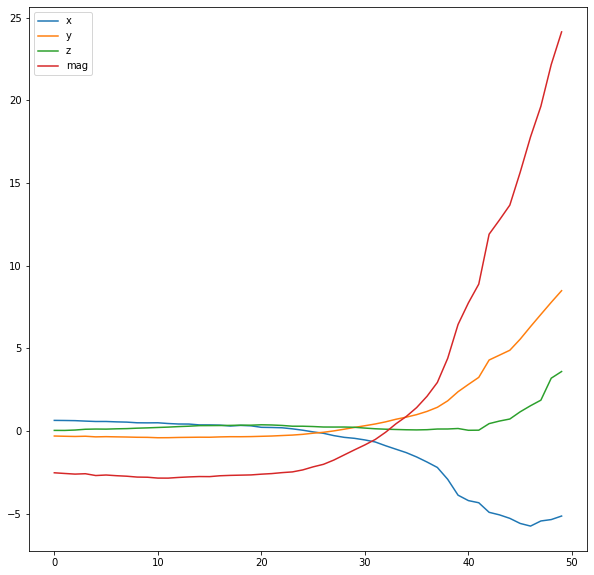

In [63]:
plt.figure(figsize = (10,10))
l1 = plt.plot(x,label = 'x')
l2 = plt.plot(y,label = 'y')
l3 = plt.plot(z,label = 'z')
l4 = plt.plot(mag,label = 'mag')
plt.legend(handles=[l1[0], l2[0],l3[0],l4[0]])
# plt.legend((x, y, z), ('label1', 'label2', 'label3'))
plt.show()

In [9]:
X_train = [S1_x, S2_x, S3_x, C1_x, C2_x]
Y_train = [S1_y, S2_y, S3_y, C1_y, C2_y]

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)

X_test = C3_x
Y_test = C3_y











































































































## Train and Test LSTM

In [142]:
def eval_lstm_simple(X_train, Y_train, X_test, Y_test, time_steps, n_features, params):
  # Build the Model
  model = Sequential()
  model.add(LSTM(params['HL_1'], activation=tf.nn.relu, input_shape=(time_steps, n_features)))
  model.add(Dropout(params['drop1']))
  model.add(BatchNormalization())
#   model.add(Dense(10, activation = tf.nn.relu))
  model.add(Dense(1, activation = tf.nn.sigmoid))
    
#   opt = keras.optimizers.Adam(learning_rate=0.001)
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = params['patience'], verbose=1)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = 'nadam', metrics=['accuracy'])

  # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
  
  # Implement class weights
  cw = {
      0: params['w0'],
      1: params['w1']
  }
  model.summary()
  # Train the model
  history = model.fit(X_train, Y_train, epochs = params['epochs'], batch_size = params['batch'], class_weight=cw, callbacks=[callback])

  # Predict on data
  Y_pred = model.predict(X_test)
  Y_pred = np.round(Y_pred, 0)
  np.where(Y_pred == 1)
  cm = confusion_matrix(Y_test, Y_pred)
  print("CONFUSION MATRIX")
  print(cm)
  print("CLASSIFICATION REPORT")
  print(classification_report(Y_test, Y_pred, target_names=["non_fall", "fall"]))
    
  return history, cm, model

In [3]:
def eval_lstm_cplx(X_train, Y_train, X_test, Y_test, time_steps, n_features, params):
  # Build the Model
  model = Sequential()
  model.add(LSTM(params['HL_1'], activation=tf.nn.relu, input_shape=(time_steps, n_features), return_sequences=True))
  model.add(Dropout(params['drop1']))
  model.add(BatchNormalization())
  model.add(LSTM(params['HL_2'], activation=tf.nn.relu))
  model.add(Dropout(params['drop2']))
  model.add(BatchNormalization())
#   model.add(Dense(10, activation = tf.nn.relu))
  model.add(Dense(1, activation = tf.nn.sigmoid))
    
  opt = keras.optimizers.Nadam(learning_rate=params['lr'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = params['patience'], verbose=1)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = opt, metrics=['accuracy'])

  # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
  
  # Implement class weights
  cw = {
      0: params['w0'],
      1: params['w1']
  }
  model.summary()
  # Train the model
  history = model.fit(X_train, Y_train, epochs = params['epochs'], batch_size = params['batch'], class_weight=cw, callbacks=[callback], verbose=0)

  # Predict on data
  Y_pred = model.predict(X_test)
  Y_pred = np.round(Y_pred, 0)
  np.where(Y_pred == 1)
  cm = confusion_matrix(Y_test, Y_pred)
  print("CONFUSION MATRIX")
  print(cm)
  print("CLASSIFICATION REPORT")
  print(classification_report(Y_test, Y_pred, target_names=["non_fall", "fall"]))
    
  return history, cm, model

In [11]:
params = { # With Feature Scaling
    'drop1' : 0.2,
    'drop2': 0.2,
    'w1' : 750.,
    'w0' : 1.,
    'batch' : 7500,
    'epochs' : 5,
    'patience' : 5,
    'HL_1' : 15,
    'HL_2' : 5,
    'lr': 0.001,
}


history, cm, model = eval_lstm_cplx(X_train, Y_train, X_test, Y_test, 50, 3, params)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 15)            1140      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 15)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 15)            60        
_________________________________________________________________
lstm_7 (LSTM)                (None, 5)                 420       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 5)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
S1_x

array([[[ 0.65048856, -0.29491472,  0.04537556],
        [ 0.6443313 , -0.30964693,  0.04340368],
        [ 0.6350953 , -0.3219238 ,  0.06706619],
        ...,
        [-5.4313917 ,  7.0589256 ,  1.8733039 ],
        [-5.346729  ,  7.7889895 ,  3.2023478 ],
        [-5.132762  ,  8.492863  ,  3.6046102 ]],

       [[ 1.1677023 ,  0.10285561,  0.03748805],
        [ 1.1738597 ,  0.09548949,  0.02467087],
        [ 1.1461518 ,  0.09385257,  0.01579743],
        ...,
        [-3.5133903 ,  4.6092825 ,  3.938843  ],
        [-3.120862  ,  4.965311  ,  4.443643  ],
        [-2.8576372 ,  5.409734  ,  5.0677414 ]],

       [[ 0.9829832 ,  0.08484954,  0.34510058],
        [ 0.9860618 ,  0.06193274,  0.31848025],
        [ 1.0183877 ,  0.04310821,  0.32143807],
        ...,
        [ 6.3875594 ,  3.4699895 ,  8.507678  ],
        [ 7.0002117 ,  3.2440953 ,  9.639534  ],
        [ 7.515886  ,  2.9838257 , 10.531808  ]],

       ...,

       [[ 1.3277924 ,  0.31729147, -0.5708354 ],
        [ 1

In [ ]:
### RUN GRID SEARCH OVERNIGHT

bs = [5000, 7500, 10000, 15000, 20000]
HL_1 = [5, 10, 15, 20, 25, 30, 35]
dr1 = [0.1, 0.2, 0.3, 0.4]
dr2 = [0.1, 0.2, 0.3, 0.4]
HL_2 = [3, 5, 10, 15, 20, 25]
weights = [500., 600., 700., 800.]
lr = [0.01, 0.001, 0.0001]

print("Number of Models:", len(bs) * len(HL_1) * len(dr1) * len(dr2) * len(HL_2) * len(weights) * len(lr))

from pprint import pprint

count = 1

for b in bs:
    for h1 in HL_1:
        for h2 in HL_2:
            for w in weights:
                for l in lr:
                    for d1 in dr1:
                        for d2 in dr2:
                            p = { # With Feature Scaling
                                'drop1' : d1,
                                'drop2': d2,
                                'w1' : w,
                                'w0' : 1.,
                                'batch' : b,
                                'epochs' : 50,
                                'patience' : 5,
                                'HL_1' : h1,
                                'HL_2' : h2,
                                'lr': l
                            }
                            print("NEW MODEL:", count)
                            print("PARAMS: ")
                            pprint(p)
                            history, cm, model = eval_lstm_cplx(X_train, Y_train, X_test, Y_test, 50, 3, p)
                            count += 1
                    

print("TRAINING DONE")

Number of Models: 40320
NEW MODEL: 1
PARAMS: 
{'HL_1': 5,
 'HL_2': 3,
 'batch': 5000,
 'drop1': 0.1,
 'drop2': 0.1,
 'epochs': 50,
 'lr': 0.01,
 'patience': 5,
 'w0': 1.0,
 'w1': 500.0}
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 50, 5)             180       
_________________________________________________________________
dropout_30 (Dropout)         (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 50, 5)             20        
_________________________________________________________________
lstm_31 (LSTM)               (None, 3)                 108       
_________________________________________________________________
dropout_31 (Dropout)         (None, 3)                 0         
_________________________________________________________________

/Users/arvganesh/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    non_fall       1.00      1.00      1.00     36769
        fall       0.00      0.00      0.00        31

    accuracy                           1.00     36800
   macro avg       0.50      0.50      0.50     36800
weighted avg       1.00      1.00      1.00     36800

NEW MODEL: 3
PARAMS: 
{'HL_1': 5,
 'HL_2': 3,
 'batch': 5000,
 'drop1': 0.1,
 'drop2': 0.3,
 'epochs': 50,
 'lr': 0.01,
 'patience': 5,
 'w0': 1.0,
 'w1': 500.0}
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 50, 5)             180       
_________________________________________________________________
dropout_34 (Dropout)         (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 50, 5)             20        
__________________________

_________________________________________________________________
dense_25 (Dense)             (None, 1)                 4         
Total params: 324
Trainable params: 308
Non-trainable params: 16
_________________________________________________________________
Epoch 00032: early stopping
CONFUSION MATRIX
[[35499  1270]
 [   10    21]]
CLASSIFICATION REPORT
              precision    recall  f1-score   support

    non_fall       1.00      0.97      0.98     36769
        fall       0.02      0.68      0.03        31

    accuracy                           0.97     36800
   macro avg       0.51      0.82      0.51     36800
weighted avg       1.00      0.97      0.98     36800

NEW MODEL: 12
PARAMS: 
{'HL_1': 5,
 'HL_2': 3,
 'batch': 5000,
 'drop1': 0.3,
 'drop2': 0.4,
 'epochs': 50,
 'lr': 0.01,
 'patience': 5,
 'w0': 1.0,
 'w1': 500.0}
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param


NEW MODEL: 16
PARAMS: 
{'HL_1': 5,
 'HL_2': 3,
 'batch': 5000,
 'drop1': 0.4,
 'drop2': 0.4,
 'epochs': 50,
 'lr': 0.01,
 'patience': 5,
 'w0': 1.0,
 'w1': 500.0}
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 50, 5)             180       
_________________________________________________________________
dropout_60 (Dropout)         (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 50, 5)             20        
_________________________________________________________________
lstm_61 (LSTM)               (None, 3)                 108       
_________________________________________________________________
dropout_61 (Dropout)         (None, 3)                 0         
_________________________________________________________________
batch_normalization_6

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    non_fall       1.00      0.94      0.97     36769
        fall       0.01      0.71      0.02        31

    accuracy                           0.94     36800
   macro avg       0.50      0.83      0.49     36800
weighted avg       1.00      0.94      0.97     36800

NEW MODEL: 25
PARAMS: 
{'HL_1': 5,
 'HL_2': 3,
 'batch': 5000,
 'drop1': 0.3,
 'drop2': 0.1,
 'epochs': 50,
 'lr': 0.001,
 'patience': 5,
 'w0': 1.0,
 'w1': 500.0}
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 50, 5)             180       
_________________________________________________________________
dropout_78 (Dropout)         (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 50, 5)             20        
__

In [26]:
params

{'drop1': 0.4,
 'drop2': 0.3,
 'w1': 750.0,
 'w0': 1.0,
 'batch': 7500,
 'epochs': 5,
 'patience': 5,
 'HL_1': 100,
 'HL_2': 50}

In [152]:
pred_y = model.predict(S2_x)
pred_y = np.round(pred_y, 0)

ValueError: in user code:

    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /Users/arvganesh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential_49: expected shape=(None, None, 3), found shape=[None, 50, 1]


In [126]:
np.where(pred_y[:30] == 0)

(array([13, 14, 15, 18, 19]), array([0, 0, 0, 0, 0]))

In [127]:
pred_y[:30]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

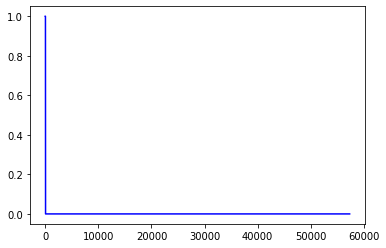

In [102]:
plt.plot(S2_y, color="blue")
# plt.plot(pred_y, color"green")
plt.show()